In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner


read data

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

important rows

In [3]:
# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ].copy()

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

ABL, ILD

In [4]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


# Aborts - LED on

In [5]:
# # led
# df_led_on_trials = df[ df['LED_trial'] == 1 ]

# # total fix < intended fix: Abort
# df_led_on_abort_trials = df_led_on_trials[ df_led_on_trials['timed_fix'] < df_led_on_trials['intended_fix'] ]

# # are there any abort trials before LED on
# df_abort_before_led = df_led_on_abort_trials[ df_led_on_abort_trials['timed_fix'] < df_led_on_abort_trials['LED_onset_time'] ]
# print('Abort trials before LED on:', len(df_abort_before_led))

# # remove them from df_led_on_abort_trials
# df_aborts_after_led = df_led_on_abort_trials[ df_led_on_abort_trials['timed_fix'] >= df_led_on_abort_trials['LED_onset_time'] ]
# print('Abort trials after LED on:', len(df_aborts_after_led))

# abort_RT = df_aborts_after_led['timed_fix'].to_numpy()

# Aborts LED off

In [6]:
df_led_off_trials = df[ df['LED_trial'] == 0]

df_abort_trials = df_led_off_trials[ df_led_off_trials['timed_fix'] < df_led_off_trials['intended_fix'] ]

abort_RT = df_abort_trials['timed_fix'].to_numpy()

# rho AI RT

In [7]:
def rho_A_t_fn(t, V_A, theta_A):
    """
    For AI,prob density of t given V_A, theta_A
    """
    if t <= 0:
        return 0
    return (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))


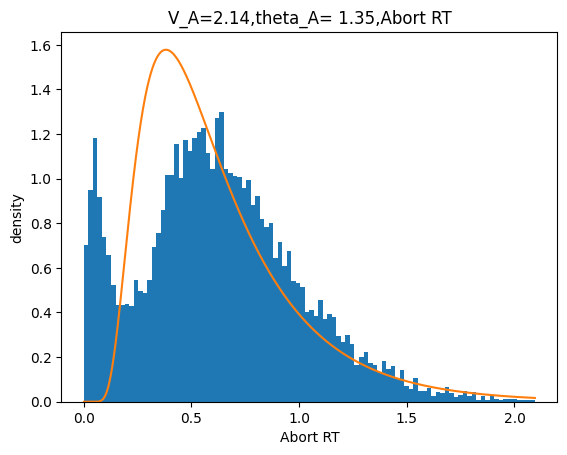

In [16]:
t_pts = np.linspace(np.min(abort_RT), np.max(abort_RT), 2000)

_lambda = (np.mean(abort_RT)**3) / np.var(abort_RT)


theta_A = np.sqrt(_lambda)

V_A = theta_A / np.mean(abort_RT)


theory_abort_pdf = [rho_A_t_fn(t, V_A, theta_A) for t in t_pts]
plt.hist(abort_RT, bins=100, density=True)
plt.plot(t_pts, theory_abort_pdf, label='theory')
plt.xlabel('Abort RT')
plt.ylabel('density')
plt.title(f'V_A={V_A:.2f},theta_A={theta_A: .2f},Abort RT');

# VBMC on Aborts LED on

## loglike fn

In [9]:
def compute_loglike(t, V_A, theta_A):
    likelihood = rho_A_t_fn(t, V_A, theta_A)

    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


def vbmc_loglike_abort_fn(params):
    V_A, theta_A = params

    # because there are less aborts, single job runs faster
    all_loglike = Parallel(n_jobs=1)(delayed(compute_loglike)(t, V_A, theta_A)\
                                       for t in abort_RT)

    loglike = np.sum(all_loglike)
    return loglike

## bounds

In [10]:
V_A_bounds = [0.01, 5]
theta_A_bounds = [0.01, 5]

V_A_plausible_bounds = [2,3]
theta_A_plausible_bounds = [1,3]

## prior

In [11]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    V_A, theta_A = params

    V_A_logpdf = trapezoidal_logpdf(V_A, V_A_bounds[0], V_A_plausible_bounds[0], V_A_plausible_bounds[1], V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])

    return V_A_logpdf + theta_A_logpdf


## prior + loglike

In [12]:
def vbmc_prior_plus_loglike_fn(params):
    return vbmc_loglike_abort_fn(params) + vbmc_prior_abort_fn(params)

## run vbmc

In [13]:
lb = [V_A_bounds[0], theta_A_bounds[0]]
ub = [V_A_bounds[1], theta_A_bounds[1]]

plb = [V_A_plausible_bounds[0], theta_A_plausible_bounds[0]]
pub = [V_A_plausible_bounds[1], theta_A_plausible_bounds[1]]

np.random.seed(42)
V_A_0 = np.random.uniform(V_A_plausible_bounds[0], V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])

x_0 = np.array([V_A_0, theta_A_0])

vbmc = VBMC(vbmc_prior_plus_loglike_fn, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 2).
Reshaping upper bounds to (1, 2).
Reshaping plausible lower bounds to (1, 2).
Reshaping plausible upper bounds to (1, 2).
Casting upper bounds to floating point.
Casting plausible lower bounds to floating point.
Casting plausible upper bounds to floating point.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9395.400 +/-0.001.


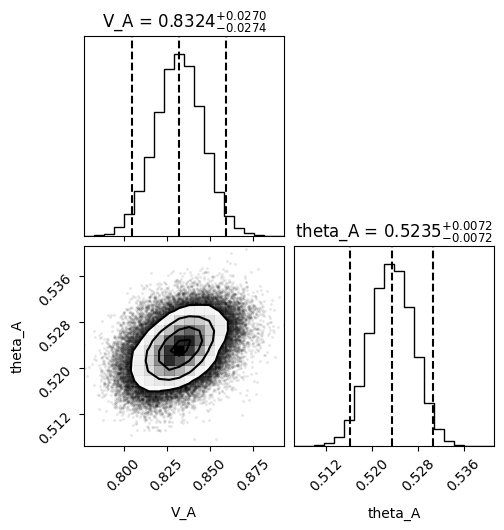

In [14]:
vp_samples = vp.sample(int(1e5))[0]

param_labels = ['V_A', 'theta_A']
percentiles = np.percentile(vp_samples, [0, 100], axis=0)


_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]


# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    title_fmt=".4f"
);